In [94]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

import math

from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

import matplotlib.pyplot as plt
%matplotlib inline

In [72]:
italy = pd.read_csv('data/Italy gas consumption.csv', index_col='Date', parse_dates=True)
italy.head()

Consumption  Mean temperature
Date                                     
2016-01-01       233.59              5.86
2016-01-02       250.99              6.87
2016-01-03       242.07              7.13
2016-01-04       286.05              7.28
2016-01-05       284.71              8.22

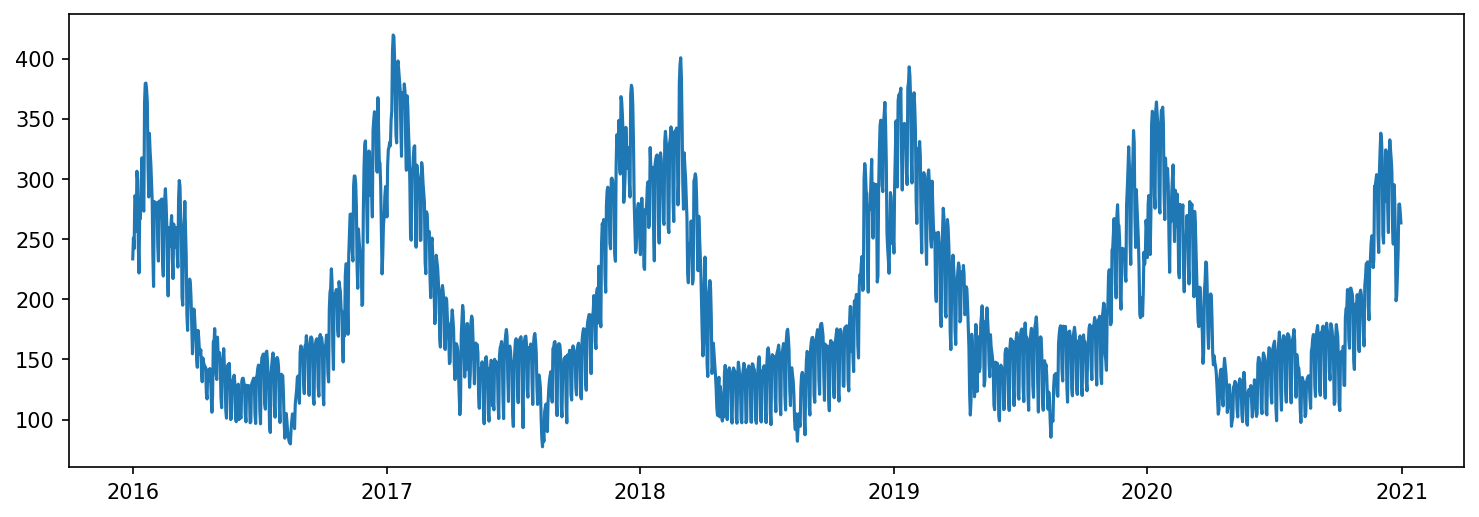

In [73]:
plt.figure(figsize=(12, 4), dpi=150)
plt.plot(italy['Consumption'])
plt.show()

In [74]:
italy['const'] = np.ones(italy.shape[0])

In [75]:
pr = italy["Mean temperature"].groupby([italy.index.month, italy.index.day]).mean()
del pr[2,29]

In [79]:
result = SARIMAX(endog=italy['Consumption'],
                 exog=italy['Mean temperature'],
                 order=(3, 0, 2),
                 seasonal_order=(1, 1, 3, 7)).fit()

D:\ForecastingMethods\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\ForecastingMethods\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\ForecastingMethods\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\ForecastingMethods\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\ForecastingMethods\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

In [80]:
result.aic

14219.873573010122

In [86]:
start = italy.index[-1] + pd.DateOffset(days=1)
end = start + pd.DateOffset(days=364)

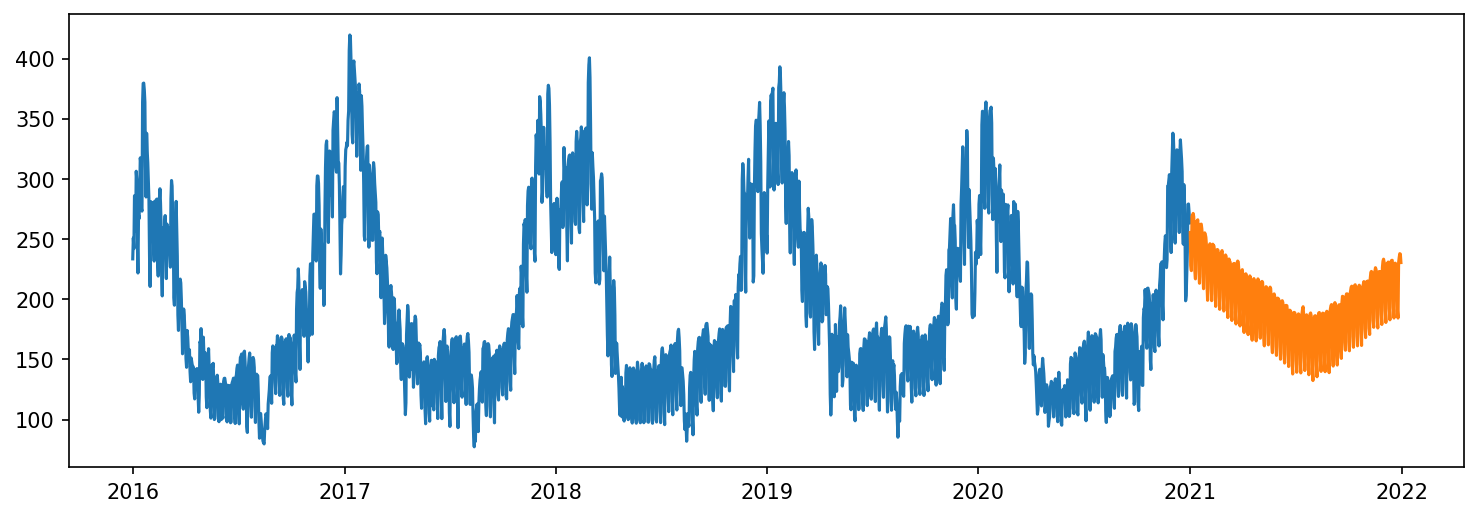

In [88]:
plt.figure(figsize=(12, 4), dpi=150)
plt.plot(italy['Consumption'])
plt.plot(result.predict(start, end, exog = pr))
plt.show()

In [125]:
X = add_constant(italy['Mean temperature'])
y = italy['Consumption']

pr = X.groupby([X.index.month, X.index.day]).mean()

In [126]:
result2 = OLS(endog=y,
                 exog=X).fit()

In [127]:
err = y - result2.fittedvalues

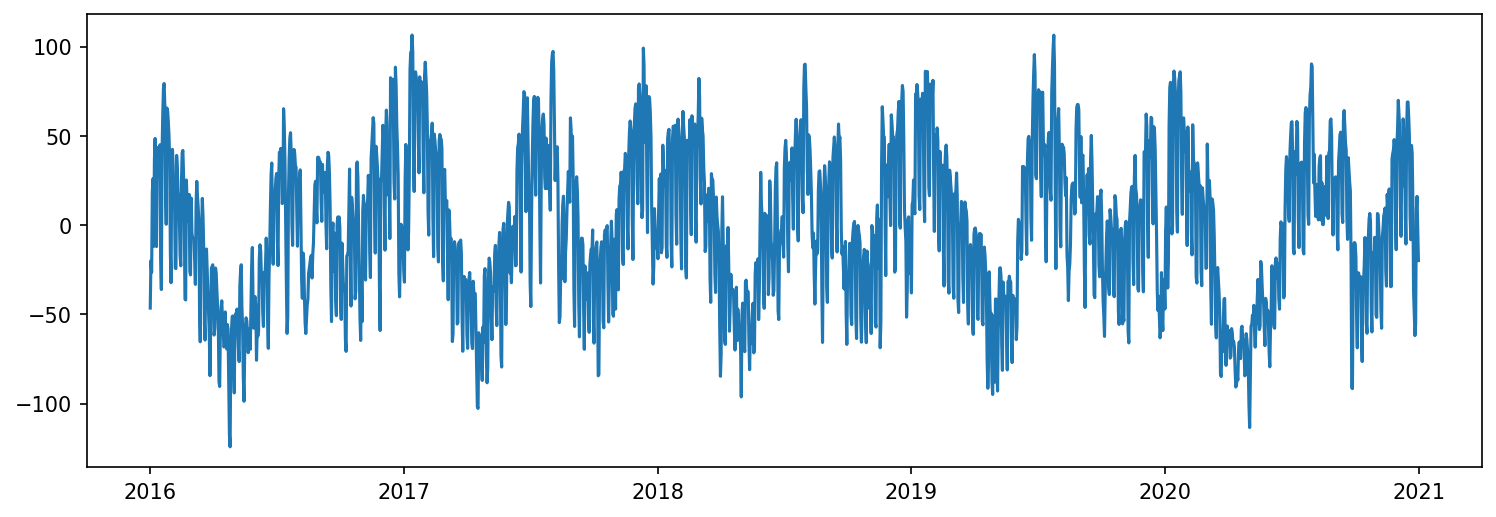

In [128]:
plt.figure(figsize=(12, 4), dpi=150)
plt.plot(err)
plt.show()

In [129]:
print("Критерий Дики-Фуллера для исходного ряда: p=%f" % adfuller(err)[1])

Критерий Дики-Фуллера для исходного ряда: p=0.000055


In [115]:
model_err = SARIMAX(endog=err,
                 order=(1, 1, 1),
                 seasonal_order=(1, 1, 2, 2)).fit()

D:\ForecastingMethods\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\ForecastingMethods\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\ForecastingMethods\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [119]:
model_err.forecast(3)

2021-01-01   -25.918757
2021-01-02   -31.957974
2021-01-03   -31.623412
Freq: D, Name: predicted_mean, dtype: float64

In [142]:
aaaa = result2.predict(exog=pr.values) + model_err.forecast(366)

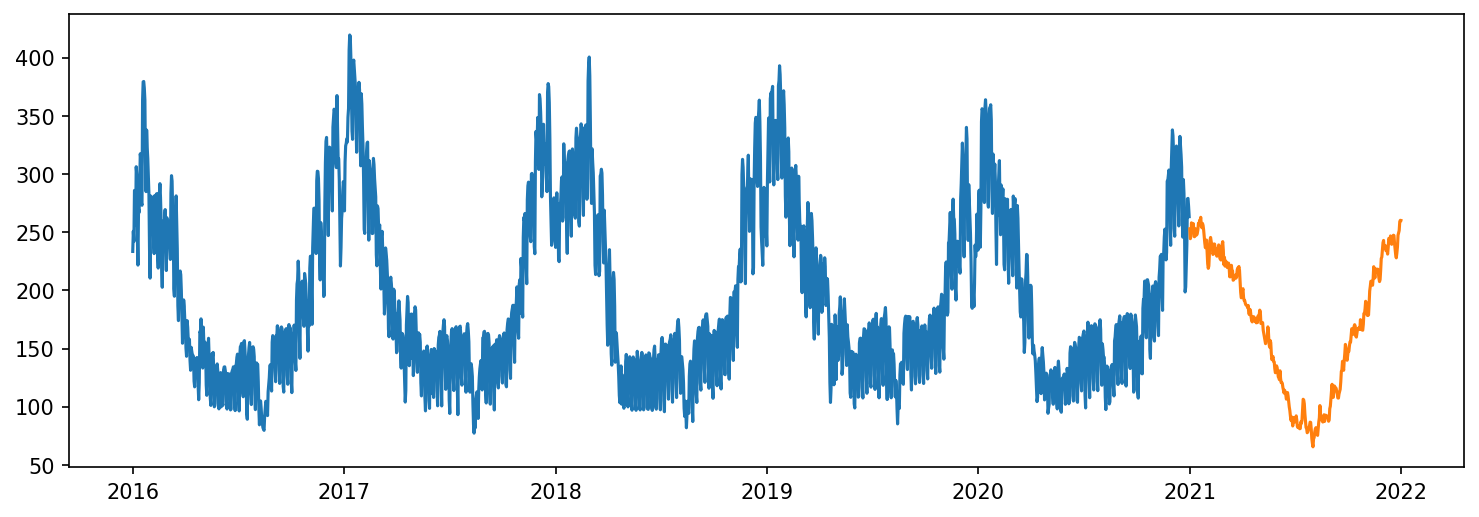

In [143]:
plt.figure(figsize=(12, 4), dpi=150)
plt.plot(italy['Consumption'])
plt.plot(aaaa)
plt.show()